<a href="https://colab.research.google.com/github/Azimoj/Home-Credit-Default-Risk/blob/main/Credit__scoring_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data contains several number of relational tables. We'll process each one of them separately, and then finally in the end, merge all of them together.

## **Preprocessing Tables**

**bureau_balance**
* First off, the bureau_balance table contains three fields, i.e. SK_ID_BUREAU, MONTHS_BALANCE and STATUS.
Since the Status follows somewhat ordinal behaviour, we start by label encoding it.
* Next, some features are created such as weighted status, which is obtained by dividing the status by the MONTHS_BALANCE.
* Since the data contains the timeseries, we also calculate the Exponential Weighted Moving Average of the Status and Weighted Status fields.
* Finally, we aggregate the data over SK_ID_BUREAU, in such a way that we first aggregate it over all the data, and after that we also aggregate over the last 2 years. These 2 years would depict the more recent behaviour of the clients.
* The aggregations performed are based on Domain Knowledge, such as mean, min, max, sum, count, etc. For EDA features, we only take the last/most recent values, as they somewhat contain the trend of all the previous values.

**bureau**
* Firstly, we merge the bureau table with the aggregated bureau_balance table from previous step, on SK_ID_BUREAU.
* We replace some erroneous values with NaN values. We saw some loans dating back to as long as 100 years ago. We believe they wouldn't really tell much about client's recent behaviour, so we remove them and only keep the loans in the period of 50 years.
* We create some features by multiplications, divisions, subtractions of raw features, based on domain knowledge, such as Credit duration, annutiy to credit ratio, etc.
* The categorical features are one-hot encoded.
* To merge these to main table, i.e. application_train, we aggregate this table over SK_ID_CURR. We perform the aggregations again in two ways. We aggregate the credits based on the CREDIT_ACTIVE category, where we aggregate for two most popular categories separately, i.e. Active, and Closed. Later we aggregate for the remaining categories too, and merge these. We aggregated the whole data overall too. The aggregations performed are sum, mean, min, max, last, etc.

In [13]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [14]:
# Data Structures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pickle
from sklearn.neighbors import KNeighborsClassifier

In [40]:
#Download databases
app_test= pd.read_csv('/content/drive/MyDrive/p7/data/application_test.csv', encoding='utf-8', low_memory=False)
app_train= pd.read_csv('/content/drive/MyDrive/p7/data/application_train.csv',low_memory=False)

In [20]:
bureau= pd.read_csv('/content/drive/MyDrive/p7/data/bureau.csv',sep=',', encoding='utf-8', low_memory=False)
bureau_balance= pd.read_csv('/content/drive/MyDrive/p7/data/bureau_balance.csv',sep=',' , encoding='utf-8', low_memory=False)
cc_balance= pd.read_csv('/content/drive/MyDrive/p7/data/credit_card_balance.csv',sep=',', encoding='utf-8', low_memory=False)

In [21]:
instal_pay= pd.read_csv('/content/drive/MyDrive/p7/data/installments_payments.csv',sep=',', encoding='utf-8', low_memory=False)
pos_cash_bal= pd.read_csv('/content/drive/MyDrive/p7/data/POS_CASH_balance.csv',sep=',', encoding='utf-8', low_memory=False)
previous_app= pd.read_csv('/content/drive/MyDrive/p7/data/previous_application.csv', encoding='utf-8',low_memory=False)
sample_submission = pd.read_csv('/content/drive/MyDrive/p7/data/sample_submission.csv', encoding='utf-8',low_memory=False)

In [22]:
hc_description= pd.read_csv('/content/drive/MyDrive/p7/data/HomeCredit_columns_description.csv', encoding='cp1252', low_memory=False)

## **application_train and application_test**

### **Imputation**

### **Data cleaning**

In [41]:

#there are some FLAG_DOCUMENT features having just one category for almost all data, we will remove those
flag_cols_to_drop = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_20']
app_train.drop(flag_cols_to_drop, axis = 1, inplace = True)
app_test.drop(flag_cols_to_drop, axis = 1, inplace= True)

#converting age from days to years
app_train['AGE'] = app_train['DAYS_BIRTH'] * -1 / 365
app_test['AGE'] = app_test['DAYS_BIRTH'] * -1 / 365

# Outliers
#From the EDA we saw some erroneous values in DAYS_EMPLOYED field
app_train['DAYS_EMPLOYED'][app_train['DAYS_EMPLOYED'] == 365243] = np.nan
app_test['DAYS_EMPLOYED'][app_test['DAYS_EMPLOYED'] == 365243] = np.nan

#there were also 4 rows with 'XNA' as Gender, removing these rows
app_train = app_train[app_train['CODE_GENDER'] != 'XNA']

#converting columns of REGION_RATING_CLIENT to object type, as we saw some complex impact on TARGET variable during EDA
app_train['REGION_RATING_CLIENT'] = app_train['REGION_RATING_CLIENT'].astype('object')
app_train['REGION_RATING_CLIENT_W_CITY'] = app_train['REGION_RATING_CLIENT_W_CITY'].astype('object')

app_test['REGION_RATING_CLIENT'] = app_test['REGION_RATING_CLIENT'].astype('object')
app_test['REGION_RATING_CLIENT_W_CITY'] = app_test['REGION_RATING_CLIENT_W_CITY'].astype('object')


### Suppression des lignes qui ont un taux de remplissage inférieur à une limite

In [42]:
find_rate =  app_train.copy()
find_rate = find_rate.replace(to_replace = '^nan$', value = np.nan, regex=True)
nb_lines = find_rate.shape[0]
nb_columns = find_rate.shape[1]
                
find_rate['taux_remplissage_lines'] = (app_train.apply(lambda x: x.count(), axis=1)/nb_columns)
    
filling_rate = []
remove_line = []

for i in range(0, 11, 1):
    taux_remplissage = i/10.0
    
    filling_rate.append(taux_remplissage*100)

    df_2 = find_rate[find_rate['taux_remplissage_lines'] > taux_remplissage]
  
            
    #number of lines in the end
    nb_lines_supp = nb_lines - df_2.shape[0]
    remove_line.append(nb_lines_supp)
  
    del df_2['taux_remplissage_lines']
    
find_rate = pd.DataFrame(
    {'filling_rate': filling_rate,
     'remove_lines': remove_line})
find_rate

,filling_rate,remove_lines
0,0.0,0
1,10.0,0
2,20.0,0
3,30.0,0
4,40.0,0
5,50.0,70
6,60.0,132473
7,70.0,154439
8,80.0,175672
9,90.0,211526


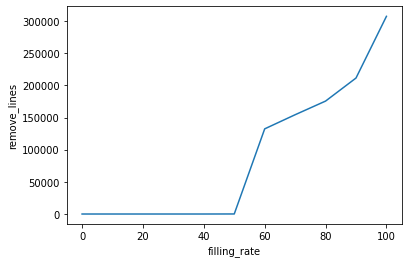

In [43]:
sns.lineplot(data=find_rate, x="filling_rate", y="remove_lines")

In [44]:
def filtration_line(dataframe, taux_remplissage):
    df = dataframe.copy()
    dataframe = dataframe.replace(to_replace = '^nan$', value = np.nan, regex=True)
    #number of line at origin
    nb_lines = dataframe.shape[0]
                
    df['taux_remplissage_lines'] = (dataframe.apply(lambda x: x.count(), axis=1)/nb_columns)

    df_2 = df[df['taux_remplissage_lines'] > taux_remplissage]
  
            
    #number of lines in the end
    nb_lines_supp = nb_lines - df_2.shape[0]

    print("Number of lines with a fill rate higher than {:.2%} : {} lines.".format(taux_remplissage, df_2.shape[0]))
    print("Number of lines deleted : {} lines".format(nb_lines_supp))
    print(df_2.shape)
    
    del df_2['taux_remplissage_lines']

    return df_2

In [45]:
app_train_clean_lines = filtration_line(app_train, 0.7)

Number of lines with a fill rate higher than 70.00% : 153068 lines.
Number of lines deleted : 154439 lines
(153068, 119)


In [20]:
app_train_clean_lines.shape

(153068, 117)

In [21]:
app_test_clean_lines = filtration_line(app_test, 0.7)

Number of lines with a fill rate higher than 70.00% : 25070 lines.
Number of lines deleted : 23674 lines
(25070, 117)


In [22]:
app_test_clean_lines.shape

(25070, 116)

### Suppression des colonnes qui ont un taux de remplissage inférieur à une limite

In [46]:
find_rate = app_train_clean_lines.copy()
find_rate = find_rate.replace(to_replace = '^nan$', value = np.nan, regex=True)
nb_colonne = find_rate.shape[1]

filling_rate = []
remove_col = []

for i in range(0, 11, 1):
    taux_remplissage = i/10.0
    
    filling_rate.append(taux_remplissage*100)

    df = find_rate[find_rate.columns[1-find_rate.isnull().mean() > taux_remplissage]]
    
    #number of columns at the end
    nb_colonne_supp = nb_colonne - df.shape[1]
    
    remove_col.append(nb_colonne_supp)
  
    
find_rate = pd.DataFrame(
    {'filling_rate': filling_rate,
     'remove_columns': remove_col
    })
find_rate 

,filling_rate,remove_columns
0,0.0,0
1,10.0,0
2,20.0,0
3,30.0,0
4,40.0,1
5,50.0,2
6,60.0,2
7,70.0,19
8,80.0,19
9,90.0,36


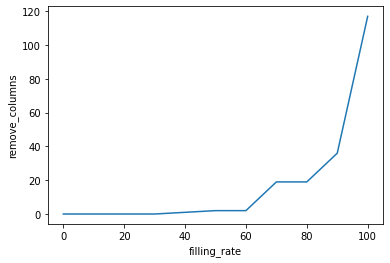

In [27]:
sns.lineplot(data=find_rate, x="filling_rate", y="remove_columns")

In [47]:
def filtration_columns(dataframe, taux_remplissage):
    dataframe = dataframe.replace(to_replace = '^nan$', value = np.nan, regex=True)
    #number of columns at origin
    nb_colonne = dataframe.shape[1]
    
    df = dataframe[dataframe.columns[1-dataframe.isnull().mean() > taux_remplissage]]

    #number of columns at the end
    nb_colonne_supp = nb_colonne - df.shape[1]

    print("Nombre de colonnes avec un taux de remplissage supérieur à {:.2%} : {} colonnes.".format(taux_remplissage, df.shape[1]))
    print("Nombre de colonnes supprimées : {} colonnes".format(nb_colonne_supp))

    return df

In [48]:
app_train_reduced = filtration_columns(app_train_clean_lines, 0.8)

Nombre de colonnes avec un taux de remplissage supérieur à 80.00% : 99 colonnes.
Nombre de colonnes supprimées : 19 colonnes


In [84]:
app_train_reduced.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,...,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,...,0.0833,0.0375,0.0193,0.0000,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,26
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,...,0.2917,0.0132,0.0558,0.0100,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,46
12,100016,0,Cash loans,F,N,Y,0,67500.0,80865.0,5881.5,67500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.031329,-13439,-2717,-311.0,-3227,1,1,1,1,1,0,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Business Entity Type 2,0.715042,...,0.1667,0.0137,0.0792,0.0000,block of flats,0.0612,NaN,No,0.0,0.0,0.0,0.0,-2370.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,37
13,100017,0,Cash loans,M,Y,N,1,225000.0,918468.0,28966.5,697500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.016612,-14086,-3028,-643.0,-4911,1,1,0,1,0,0,3.0,2,2,THURSDAY,13,0,0,0,0,0,0,Self-employed,0.566907,...,0.3333,0.0947,0.1422,0.0000,block of flats,0.1417,Panel,No,0.0,0.0,0.0,0.0,-4.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,39
14,100018,0,Cash loans,F,N,Y,0,189000.0,773680.5,32778.0,679500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010006,-14583,-203,-615.0,-2056,1,1,0,1,0,0,2.0,2,1,MONDAY,9,0,0,0,0,0,0,Transport: type 2,0.642656,...,0.6667,0.1789,0.3842,0.1022,block of flats,0.3811,Panel,No,0.0,0.0,0.0,0.0,-188.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,40


In [49]:
app_train_reduced.shape

(153068, 99)

In [50]:
if 'EXT_SOURCE_1' in app_train_reduced.columns:
    print("The column EXT_SOURCE_1 is in the datatset.")
else :
    app_train_reduced['EXT_SOURCE_1'] = app_train_clean_lines['EXT_SOURCE_1']
    print("The column EXT_SOURCE_1 has been added to the dataset.")

if 'EXT_SOURCE_2' in app_train_reduced.columns:
    print("The column EXT_SOURCE_2 is in the datatset.")
else :
    app_train_reduced['EXT_SOURCE_2'] = app_train_clean_lines['EXT_SOURCE_2']
    print("The column EXT_SOURCE_2 has been added to the dataset.")
    
if 'EXT_SOURCE_3' in app_train_reduced.columns:
    print("The column EXT_SOURCE_3 is in the datatset.")
else :
    app_train_reduced['EXT_SOURCE_3'] = app_train_clean_lines['EXT_SOURCE_3']
    print("The column EXT_SOURCE_3 has been added to the dataset.")
#----------------------------------------------------------------------------    

if 'DAYS_EMPLOYED' in app_train_reduced.columns:
    print("The column DAYS_EMPLOYED is in the datatset.")
else :
    app_train_reduced['DAYS_EMPLOYED'] = app_train_clean_lines['DAYS_EMPLOYED']
    print("The column DAYS_EMPLOYED has been added to the dataset.")
#----------------------------------------------------------------------------    
    
if 'DAYS_BIRTH' in app_train_reduced.columns:
    print("The column DAYS_BIRTH is in the datatset.")
else :
    app_train_reduced['DAYS_BIRTH'] = app_train_clean_lines['DAYS_BIRTH']
    print("The column DAYS_BIRTH has been added to the dataset.")
    
#----------------------------------------------------------------------------    

if 'AGE' in app_train_reduced.columns:
    print("The column AGE is in the datatset.")
else :
    app_train_reduced['AGE'] = app_train_clean_lines['AGE']
    print("The column AGE has been added to the dataset.")

The column EXT_SOURCE_1 has been added to the dataset.
The column EXT_SOURCE_2 is in the datatset.
The column EXT_SOURCE_3 is in the datatset.
The column DAYS_EMPLOYED is in the datatset.
The column DAYS_BIRTH is in the datatset.
The column AGE is in the datatset.


In [52]:
app_train_reduced.shape

(153068, 100)

In [56]:
filter_columns = list(app_train_reduced.columns)


In [ ]:
"""def remove_miss_value(df):
   column_with_nan = df.columns[df.isnull().any()]
   for column in column_with_nan:
     if df[column].isnull().sum()*100.0/df.shape[0] > 60:
       df.drop(column,1, inplace=True)
   return (df)"""

In [57]:
def remove_columns(dataframe, filter_columns):
    """dataframe : dataframe to filter
    filter_columns : columns to keep"""
    new = pd.DataFrame()

    for column in filter_columns:
        try:
            new[column] = dataframe[column]
        except:
            print('...colonne non présente : ', column)
            print('\n')
    print("All selected columns have been kept from the dataset")
    return new

In [58]:
app_test_reduced = remove_columns(app_test_clean_lines, filter_columns)

...colonne non présente :  TARGET


...colonne non présente :  AGE


All selected columns have been kept from the dataset


In [59]:
set(app_test.columns).difference(set(app_train.columns))

set()

In [ ]:
set(app_train.columns).difference(set(app_test.columns))

### **Imputation**

* **Train**

In [60]:
"""#Imputation with pandas 
def imputation_pandas(dataframe):
  short_cleaned_impute = dataframe.copy()
  for col_name in dataframe:
    short_cleaned_impute[col_name] = dataframe[col_name].interpolate(method='linear', inplace=False, limit_direction="both").ffill().bfill()
    
  return short_cleaned_impute"""

In [63]:
def filling_num_miss_value(df):
  column_with_nan = df.columns[df.isnull().any()]
  for column in column_with_nan:
    if df[column].dtypes=='O':
      df[column]= df[column].fillna(df[column].mode()[0])
    else:
      df[column]= df[column].fillna(df[column].median())
  return (df)

In [92]:
app_train_reduced.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [64]:
app_train_fin= filling_num_miss_value(app_train_reduced)
app_test_fin= filling_num_miss_value(app_test_reduced)

In [66]:
app_train_fin.isnull().sum().sort_values(ascending=False)

SK_ID_CURR                     0
ENTRANCES_MEDI                 0
DEF_30_CNT_SOCIAL_CIRCLE       0
OBS_30_CNT_SOCIAL_CIRCLE       0
EMERGENCYSTATE_MODE            0
                              ..
WEEKDAY_APPR_PROCESS_START     0
REGION_RATING_CLIENT_W_CITY    0
REGION_RATING_CLIENT           0
CNT_FAM_MEMBERS                0
EXT_SOURCE_1                   0
Length: 100, dtype: int64

* **Test**

In [100]:
# Df des features numériques.
df_num_test = app_test_reduced.select_dtypes('number').reset_index(drop = True)

# Df des features catégoriques.
df_categ_test = app_test_reduced.select_dtypes('object').reset_index(drop = True)

In [101]:
df_num_imputed_test = imputation_pandas(df_num_test)

In [102]:
df_categ_test = df_categ_test.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [103]:
app_test_final = pd.concat([df_num_imputed_test, df_categ_test], axis=1)

In [104]:
app_test_final = app_test_final.reset_index()
del app_test_final['index']

In [105]:
app_train_final['SK_ID_CURR']=app_train_final['SK_ID_CURR'].astype('object')
app_train_final['TARGET']=app_train_final['TARGET'].astype('object')
app_test_final['SK_ID_CURR']=app_test_final['SK_ID_CURR'].astype('object')

### **Standardisation (Train + Test)**

In [106]:
df_num_train = app_train_final.select_dtypes(['number']).reset_index(drop = True)
df_categ_train = app_train_final.select_dtypes('object').reset_index(drop = True)

df_num_test = app_test_final.select_dtypes(['number']).reset_index(drop = True)
df_categ_test = app_test_final.select_dtypes('object').reset_index(drop = True)

In [107]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(df_num_train)


df_num_train_train = pd.DataFrame(scaler.transform(df_num_train), index=df_num_train.index, columns=df_num_train.columns)
df_num_test_test = pd.DataFrame(scaler.transform(df_num_test), index=df_num_test.index, columns=df_num_test.columns)

In [108]:
df_app_train = pd.concat([df_categ_train, df_num_train_train], axis=1)
df_app_test = pd.concat([df_categ_test, df_num_test_test], axis=1)

In [109]:
df_app_train.shape

(153794, 105)

In [110]:
df_app_test.shape

(25227, 104)

### **Encoding (Train + Test)**

for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot.

In [113]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0
oh_count = 0

# Iterate through the columns
for col in df_app_train:
    if col == 'TARGET' or col == 'SK_ID_CURR':
        pass
    else :
        if df_app_train[col].dtype == 'object':        
        # If 2 or fewer unique categories
            if len(list(df_app_train[col].unique())) <= 2:
                # Train on the training data
                le.fit(df_app_train[col])
                # Transform both training and testing data
                df_app_train[col] = le.transform(df_app_train[col])
                df_app_test[col] = le.transform(df_app_test[col])
            
            # Keep track of how many columns were label encoded
                le_count += 1
                
            else :
                #else : one hot encoding
                df_app_train = pd.get_dummies(df_app_train, prefix=[col], columns=[col])
                df_app_test = pd.get_dummies(df_app_test, prefix=[col], columns=[col])
                oh_count += 1
                
print('%d columns were label encoded.' % le_count)
print('Training Features shape: ', df_app_train.shape)
print('Testing Features shape: ', df_app_test.shape)
print('%d columns were one hot encoded.' % oh_count)

4 columns were label encoded.
Training Features shape:  (153794, 205)
Testing Features shape:  (25227, 198)
10 columns were one hot encoded.


There must be the same characteristics (columns) in the training and test data. The encoding created more columns in the training data because some categorical variables had more unrepresented categories than in the test data. To remove the columns in the training data that are not in the test data, we need to align the dataframes. First, we extract the target column from the training data (because it is not in the test data but we need to keep this information). When we do the alignment, we need to make sure to set axis=1 to align the dataframes to the columns and not the rows.

In [114]:
train_labels = df_app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
df_app_train, df_app_test = df_app_train.align(df_app_test, join = 'inner', axis = 1)

# Add the target back in
df_app_train['TARGET'] = train_labels

print('Training Features shape: ', df_app_train.shape)
print('Testing Features shape: ', df_app_test.shape)

Training Features shape:  (153794, 199)
Testing Features shape:  (25227, 198)


In [115]:
app_train_final.to_csv("train_imputed_without_standardisation.csv", index=False)
app_test_final.to_csv("test_imputed_without_standardisation.csv", index=False)

**Backup CSVs**

In [116]:
df_app_train.to_csv("df_train_imputed.csv", index=False)
df_app_test.to_csv("df_test_imputed.csv", index=False)

In [1]:
app_train_reduced.to_csv("real_data_clean_train.csv", index=False)
app_test_reduced.to_csv("real_data_clean_test.csv", index=False)

NameError: ignored

## **Modeling**

In [ ]:
app_test.shape

(48744, 104)

In [ ]:
app_train.shape

(307511, 105)

In [ ]:
app_train= filling_num_miss_value(app_train)
app_test= filling_num_miss_value(app_test)

1- First we start with cleaning the data by removing the outliers. We also remove the rows in train data with categories such that those categories do not appear in test data. We also convert the Region Rating features to categorical becuase we saw from the EDA that they don't follow an ordinal beviour when it comes to Defaulting Characteristics.

2-Inspired from the winner's writeup for the problem, we also predict the missing values of EXT_SOURCE features by building a regression model on the rest of the numeric features.

3-Next we do feature engineering on the numeric features, and generate features based on Domain Knoweldge, such as INCOME TO ANNUITY ratio, EXT_SOURCE means, etc.

4-We also try to predict the interest rates by using the data from the previous applications features, and predicting using the data from application_train features. We also create a feature based on the Target values from application_train where we compute the mean of targets of 500 nearest neighbors of each row.

5-Next we create some features based on the categorical interactions by grouping the data on several categorical combinations and imputing the aggregates for each group as features.

6-We encode the categorical features by response coding, as we didn't want to increase dimensionality by many-folds using OHE.

### **Feature Engineering**

In [ ]:
app_train['AMT_INCOME_TOTAL']+0.00001

0         202500.00001
1         270000.00001
2          67500.00001
3         135000.00001
4         121500.00001
              ...     
307506    157500.00001
307507     72000.00001
307508    153000.00001
307509    171000.00001
307510    157500.00001
Name: AMT_INCOME_TOTAL, Length: 307507, dtype: float64

In [ ]:
app_train['AMT_CREDIT']

0          406597.5
1         1293502.5
2          135000.0
3          312682.5
4          513000.0
            ...    
307506     254700.0
307507     269550.0
307508     677664.0
307509     370107.0
307510     675000.0
Name: AMT_CREDIT, Length: 307507, dtype: float64

In [9]:
def numeric_feature_engineering(data):
        
  #income and credit features
  data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
  data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / (data['AMT_ANNUITY'] + 0.00001)
  data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
  data['INCOME_ANNUITY_DIFF'] = data['AMT_INCOME_TOTAL'] - data['AMT_ANNUITY']
  data['CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / (data['AMT_GOODS_PRICE'] + 0.00001)
  data['CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE'] + 0.00001
  data['GOODS_INCOME_RATIO'] = data['AMT_GOODS_PRICE'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
  data['INCOME_EXT_RATIO'] = data['AMT_INCOME_TOTAL'] / (data['EXT_SOURCE_3'] + 0.00001)
  data['CREDIT_EXT_RATIO'] = data['AMT_CREDIT'] / (data['EXT_SOURCE_3'] + 0.00001)

  #age ratios and diffs
  data['AGE_EMPLOYED_DIFF'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
  data['EMPLOYED_TO_AGE_RATIO'] = data['DAYS_EMPLOYED'] / (data['DAYS_BIRTH'] + 0.00001)

  #car ratios
  data['CAR_EMPLOYED_DIFF'] = data['OWN_CAR_AGE'] - data['DAYS_EMPLOYED']
  data['CAR_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_EMPLOYED']+0.00001)
  data['CAR_AGE_DIFF'] = data['DAYS_BIRTH'] - data['OWN_CAR_AGE']
  data['CAR_AGE_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_BIRTH'] + 0.00001)

  #flag contacts sum
  data['FLAG_CONTACTS_SUM'] = data['FLAG_MOBIL'] + data['FLAG_EMP_PHONE'] + data['FLAG_WORK_PHONE'] + data[
                              'FLAG_CONT_MOBILE'] + data['FLAG_PHONE'] + data['FLAG_EMAIL']
  
  data['HOUR_PROCESS_CREDIT_MUL'] = data['AMT_CREDIT'] * data['HOUR_APPR_PROCESS_START']

  #family members
  data['CNT_NON_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']
  data['CHILDREN_INCOME_RATIO'] = data['CNT_CHILDREN'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
  data['PER_CAPITA_INCOME'] = data['AMT_INCOME_TOTAL'] / (data['CNT_FAM_MEMBERS'] + 1)

  #region ratings
  data['REGIONS_RATING_INCOME_MUL'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) * data['AMT_INCOME_TOTAL'] / 2
  data['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
  data['REGION_RATING_MAX'] = [min(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
  data['REGION_RATING_MEAN'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) / 2
  data['REGION_RATING_MUL'] = data['REGION_RATING_CLIENT'] * data['REGION_RATING_CLIENT_W_CITY']

  #flag regions
  data['FLAG_REGIONS'] = data['REG_REGION_NOT_LIVE_REGION'] + data['REG_REGION_NOT_WORK_REGION'] + data['LIVE_REGION_NOT_WORK_REGION']+data[
                          'REG_CITY_NOT_LIVE_CITY'] + data['REG_CITY_NOT_WORK_CITY'] + data['LIVE_CITY_NOT_WORK_CITY']   
  
  #ext_sources,  Normalized score from external data source.
  data['EXT_SOURCE_MEAN'] = (data['EXT_SOURCE_1'] + data['EXT_SOURCE_2'] + data['EXT_SOURCE_3'] ) / 3
  data['EXT_SOURCE_MUL'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3'] 
  data['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
  data['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
  data['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
  data['WEIGHTED_EXT_SOURCE'] =  data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 3 + data.EXT_SOURCE_3 * 4

  #apartment scores
  data['APARTMENTS_SUM_AVG'] = data['APARTMENTS_AVG'] + data['BASEMENTAREA_AVG'] + data['YEARS_BEGINEXPLUATATION_AVG'] + data[
                              'YEARS_BUILD_AVG'] + data['COMMONAREA_AVG'] + data['ELEVATORS_AVG'] + data['ENTRANCES_AVG'] + data[
                              'FLOORSMAX_AVG'] + data['FLOORSMIN_AVG'] + data['LANDAREA_AVG'] + data['LIVINGAPARTMENTS_AVG'] + data[
                              'LIVINGAREA_AVG'] + data['NONLIVINGAPARTMENTS_AVG'] + data['NONLIVINGAREA_AVG']

  data['APARTMENTS_SUM_MODE'] = data['APARTMENTS_MODE'] + data['BASEMENTAREA_MODE'] + data['YEARS_BEGINEXPLUATATION_MODE'] + data[
                              'YEARS_BUILD_MODE'] + data['COMMONAREA_MODE'] + data['ELEVATORS_MODE'] + data['ENTRANCES_MODE'] + data[
                              'FLOORSMAX_MODE'] + data['FLOORSMIN_MODE'] + data['LANDAREA_MODE'] + data['LIVINGAPARTMENTS_MODE'] + data[
                              'LIVINGAREA_MODE'] + data['NONLIVINGAPARTMENTS_MODE'] + data['NONLIVINGAREA_MODE'] + data['TOTALAREA_MODE']

  data['APARTMENTS_SUM_MEDI'] = data['APARTMENTS_MEDI'] + data['BASEMENTAREA_MEDI'] + data['YEARS_BEGINEXPLUATATION_MEDI'] + data[
                              'YEARS_BUILD_MEDI'] + data['COMMONAREA_MEDI'] + data['ELEVATORS_MEDI'] + data['ENTRANCES_MEDI'] + data[
                              'FLOORSMAX_MEDI'] + data['FLOORSMIN_MEDI'] + data['LANDAREA_MEDI'] + data['LIVINGAPARTMENTS_MEDI'] + data[
                              'LIVINGAREA_MEDI'] + data['NONLIVINGAPARTMENTS_MEDI'] + data['NONLIVINGAREA_MEDI']
  data['INCOME_APARTMENT_AVG_MUL'] = data['APARTMENTS_SUM_AVG'] * data['AMT_INCOME_TOTAL']
  data['INCOME_APARTMENT_MODE_MUL'] = data['APARTMENTS_SUM_MODE'] * data['AMT_INCOME_TOTAL']
  data['INCOME_APARTMENT_MEDI_MUL'] = data['APARTMENTS_SUM_MEDI'] * data['AMT_INCOME_TOTAL']
  
  #OBS And DEF
  data['OBS_30_60_SUM'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['OBS_60_CNT_SOCIAL_CIRCLE']
  data['DEF_30_60_SUM'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
  data['OBS_DEF_30_MUL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] *  data['DEF_30_CNT_SOCIAL_CIRCLE']
  data['OBS_DEF_60_MUL'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] *  data['DEF_60_CNT_SOCIAL_CIRCLE']
  data['SUM_OBS_DEF_ALL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['DEF_30_CNT_SOCIAL_CIRCLE'] + data[
                              'OBS_60_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
  data['OBS_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
  data['OBS_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
  data['DEF_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
  data['DEF_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
  
  #Flag Documents combined
  data['SUM_FLAGS_DOCUMENTS'] = data['FLAG_DOCUMENT_3'] + data['FLAG_DOCUMENT_5'] + data['FLAG_DOCUMENT_6']  + data[
                              'FLAG_DOCUMENT_7'] + data['FLAG_DOCUMENT_8'] + data['FLAG_DOCUMENT_9'] + data[
                              'FLAG_DOCUMENT_11'] + data['FLAG_DOCUMENT_13'] + data['FLAG_DOCUMENT_14'] + data[
                              'FLAG_DOCUMENT_15'] + data['FLAG_DOCUMENT_16'] + data['FLAG_DOCUMENT_17'] + data[
                              'FLAG_DOCUMENT_18'] + data['FLAG_DOCUMENT_19'] + data['FLAG_DOCUMENT_21']
  #details change
  data['DAYS_DETAILS_CHANGE_MUL'] = data['DAYS_LAST_PHONE_CHANGE'] * data['DAYS_REGISTRATION'] * data['DAYS_ID_PUBLISH']
  data['DAYS_DETAILS_CHANGE_SUM'] = data['DAYS_LAST_PHONE_CHANGE'] + data['DAYS_REGISTRATION'] + data['DAYS_ID_PUBLISH']
              
  return data

In [11]:
#Creating Numeric features based on domain knowledge
app_train = numeric_feature_engineering(app_train)
app_test = numeric_feature_engineering(app_test)

In [12]:
app_train.shape

(307507, 166)

In [13]:
# -- FEATURE ENGINEERING : super variable gagnant concours kaggle

def feature_engineering_neighbors_EXT_SOURCE(data):
    '''
     - Imputation de la moyenne des 500 valeurs cibles des voisins les plus
       proches pour chaque application du train set ou test set.
     - Les voisins sont calculés en utilisant :
       - les variables très importantes :
       - EXT_SOURCE-1,
       - EXT_SOURCE_2
       - et EXT_SOURCE_3,
     - et CREDIT_ANNUITY_RATIO (ratio du Montant du crédit du prêt / Annuité de prêt).
     [Source](https://www.kaggle.com/c/home-credit-default-risk/discussion/64821)
     Inputs: dataframe pour lequel on veut ajouter la variable des 500 plus
             proches voisins.
     Returns:
         None
     '''

    knn = KNeighborsClassifier(500, n_jobs=-1)

    train_data_for_neighbors = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATIO']].fillna(0)

    # saving the training data for neighbors
    with open('TARGET_MEAN_500_Neighbors_training_data.pkl', 'wb') as f:
         pickle.dump(train_data_for_neighbors, f)
    train_target = app_train.TARGET
    test_data_for_neighbors = app_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATIO']].fillna(0)

    knn.fit(train_data_for_neighbors, train_target)
    # pickling the knn model
    with open('KNN_model_TARGET_500_neighbors.pkl', 'wb') as f:
         pickle.dump(knn, f)

    train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
    test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]

    # adding the means of targets of 500 neighbors to new column
    app_train['TARGET_NEIGHBORS_500_MEAN'] = [app_train['TARGET'].iloc[ele].mean() for ele in train_500_neighbors]
    app_test['TARGET_NEIGHBORS_500_MEAN'] = [app_test['TARGET'].iloc[ele].mean() for ele in train_500_neighbors]

In [14]:
app_train = feature_engineering_neighbors_EXT_SOURCE(app_train)
app_test = feature_engineering_neighbors_EXT_SOURCE(app_test)

TypeError: ignored

## $\color{red}{\text{T.B.C}}$

In [16]:
def categorical_interaction_features(train_data, test_data):
    '''
    Function to generate some features based on categorical groupings.
    
    Inputs:
        self
        train_data, test_data : DataFrames
            train and test dataframes
    
    Returns:
        Train and test datasets, with added categorical interaction features.
    '''
    
    #now we will create features based on categorical interactions
    columns_to_aggregate_on = [
        ['NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE'],
        ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE'],
        ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE'],
        ['NAME_EDUCATION_TYPE','NAME_INCOME_TYPE','OCCUPATION_TYPE'],
        ['OCCUPATION_TYPE','ORGANIZATION_TYPE'],
        ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY']

    ]
    aggregations = {
        'AMT_ANNUITY' : ['mean','max','min'],
        'ANNUITY_INCOME_RATIO' : ['mean','max','min'],
        'AGE_EMPLOYED_DIFF' : ['mean','min'],
        'AMT_INCOME_TOTAL' : ['mean','max','min'],
        'APARTMENTS_SUM_AVG' : ['mean','max','min'],
        'APARTMENTS_SUM_MEDI' : ['mean','max','min'],
        'EXT_SOURCE_MEAN' : ['mean','max','min'],
        'EXT_SOURCE_1' : ['mean','max','min'],
        'EXT_SOURCE_2' : ['mean','max','min'],
        'EXT_SOURCE_3' : ['mean','max','min']
    }
      #extracting values
    for group in columns_to_aggregate_on:
        #grouping based on categories
        grouped_interactions = train_data.groupby(group).agg(aggregations) 
        grouped_interactions.columns = ['_'.join(ele).upper() + '_AGG_' + '_'.join(group) for ele in grouped_interactions.columns]
        #saving the grouped interactions to pickle file
        group_name = '_'.join(group)
        with open(f'Application_train_grouped_interactions_{group_name}.pkl', 'wb') as f:
            pickle.dump(grouped_interactions, f)
        #merging with the original data
        train_data = train_data.join(grouped_interactions, on = group)
        test_data = test_data.join(grouped_interactions, on = group)

    return train_data, test_data
    

In [18]:
categorical_interaction_features(app_train, app_test)


AttributeError: ignored

In [ ]:
def response_fit(self, data, column):
    '''
    Response Encoding Fit Function
    Function to create a vocabulary with the probability of occurrence of each category for categorical features
    for a given class label.
    
    Inputs:
        self
        data: DataFrame
            training Dataset
        column: str
            the categorical column for which vocab is to be generated
    
    Returns:
        Dictionary of probability of occurrence of each category in a particular class label.
    '''
    
    dict_occurrences = {1: {}, 0: {}}
    for label in [0,1]:
        dict_occurrences[label] = dict((data[column][data.TARGET == label].value_counts() / data[column].value_counts()).fillna(0))

    return dict_occurrences

In [ ]:
def response_transform(self, data, column, dict_mapping):
    '''
    Response Encoding Transform Function
    Function to transform the categorical feature into two features, which contain the probability
    of occurrence of that category for each class label.
    
    Inputs:
        self
        data: DataFrame
            DataFrame whose categorical features are to be encoded
        column: str
            categorical column whose encoding is to be done
        dict_mapping: dict
            Dictionary obtained from Response Fit function for that particular column
    
    Returns:
        None
    '''
    
    data[column + '_0'] = data[column].map(dict_mapping[0])
    data[column + '_1'] = data[column].map(dict_mapping[1])

In [ ]:
def cnt_payment_prediction(self, data_to_predict):
    '''
    Function to predict the Count_payments on Current Loans using data from previous loans.
    
    Inputs:
        self
        data_to_predict: DataFrame
            the values using which the model would predict the Count_payments on current applications
    
    Returns:
        Predicted Count_payments of the current applications.
    '''
    
    #https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
    previous_application = pd.read_csv('previous_application.csv')
    train_data = previous_application[['AMT_CREDIT', 'AMT_ANNUITY', 'CNT_PAYMENT']].dropna()
    train_data['CREDIT_ANNUITY_RATIO'] = train_data['AMT_CREDIT'] / (train_data['AMT_ANNUITY'] + 1)
    #value to predict is our CNT_PAYMENT
    train_value = train_data.pop('CNT_PAYMENT')
    
    #test data would be our application_train data
    test_data = data_to_predict[['AMT_CREDIT','AMT_ANNUITY']].fillna(0)
    test_data['CREDIT_ANNUITY_RATIO'] = test_data['AMT_CREDIT'] / (test_data['AMT_ANNUITY'] + 1)
    
    lgbmr = LGBMRegressor(max_depth = 9, n_estimators = 5000, n_jobs = -1, learning_rate = 0.3, 
                          random_state = 125)
    lgbmr.fit(train_data, train_value)
    #dumping the model to pickle file
    with open('cnt_payment_predictor_lgbmr.pkl', 'wb') as f:
        pickle.dump(lgbmr, f)
    #predicting the CNT_PAYMENT for test_data
    cnt_payment = lgbmr.predict(test_data)
    
    return cnt_payment


In [ ]:
def main(self):
    '''
    Function to be called for complete preprocessing of application_train and application_test tables.
    
    Inputs:
        self
        
    Returns:
        Final pre=processed application_train and application_test tables.
    '''

    #loading the DataFrames first
    self.load_dataframes()
    #first doing Data Cleaning
    self.data_cleaning()
    #predicting the missing values of EXT_SOURCE columns
    self.ext_source_values_predictor()
    
    #doing the feature engineering
    if self.verbose:
        start = datetime.now()
        print("\nStarting Feature Engineering...")
        print("\nCreating Domain Based Features on Numeric Data")
    #Creating Numeric features based on domain knowledge
    self.application_train = self.numeric_feature_engineering(self.application_train)
    self.application_test = self.numeric_feature_engineering(self.application_test)
    #500 Neighbors Target mean
    self.neighbors_EXT_SOURCE_feature()
    if self.verbose:
        print("Done.")
        print(f"Time Taken = {datetime.now() - start}")

    if self.verbose:
        start = datetime.now()
        print("Creating features based on Categorical Interactions on some Numeric Features")
    #creating features based on categorical interactions
    self.application_train, self.application_test = self.categorical_interaction_features(self.application_train, self.application_test)   
    if self.verbose:
        print("Done.")
                    print(f"Time taken = {datetime.now() - start}")
    
    #using response coding on categorical features, to keep the dimensionality in check
    #categorical columns to perform response coding on
    categorical_columns_application = self.application_train.dtypes[self.application_train.dtypes == 'object'].index.tolist()
    for col in categorical_columns_application:
        #extracting the dictionary with values corresponding to TARGET variable 0 and 1 for each of the categories
        mapping_dictionary = self.response_fit(self.application_train, col)
        #saving the mapping dictionary to pickle file
        with open(f'Response_coding_dict_{col}.pkl', 'wb') as f:
            pickle.dump(mapping_dictionary, f)
        #mapping this dictionary with our DataFrame
        self.response_transform(self.application_train, col, mapping_dictionary)
        self.response_transform(self.application_test, col, mapping_dictionary)
        #removing the original categorical columns
        _ = self.application_train.pop(col)
        _ = self.application_test.pop(col)
    
    if self.verbose:
        print('Done preprocessing appplication_train and application_test.')
        print(f"\nInitial Size of application_train: {self.initial_shape}")
        print(f'Size of application_train after Pre-Processing and Feature Engineering: {self.application_train.shape}')
        print(f'\nTotal Time Taken = {datetime.now() - self.start}')

    if self.dump_to_pickle:
        if self.verbose:
            print('\nPickling pre-processed application_train and application_test to application_train_preprocessed.pkl and application_test_preprocessed, respectively.')
        with open(self.file_directory + 'application_train_preprocessed.pkl', 'wb') as f:
            pickle.dump(self.application_train, f)
        with open(self.file_directory + 'application_test_preprocessed.pkl', 'wb') as f:
            pickle.dump(self.application_test, f)
        if self.verbose:
            print('Done.')  
    if self.verbose:
        print('-'*100)
    return self.application_train, self.application_test

In [ ]:
application_train, application_test = preprocess_application_train_test(dump_to_pickle = True).main()

NameError: ignored

In [ ]:
# - AGGREGATION DES VARIABLES STATISTIQUES des VAR QUANTITATIVES

def agg_var_num(dataframe, group_var, dict_agg, prefix):
    """
    Aggregates the numeric values in a dataframe.
    This can be used to create features for each instance of the grouping variable.
    Parameters
    --------
        dataframe (dataframe): the dataframe to calculate the statistics on
        group_var (string): the variable by which to group df
        df_name (string): the variable used to rename the columns
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            some statistics (mean, min, max, sum ...) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in dataframe:
        if col != group_var and 'SK_ID' in col:
            dataframe = dataframe.drop(columns=col)

    group_ids = dataframe[group_var]
    numeric_df = dataframe.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(dict_agg)

    # Ajout suffix mean, sum...
    agg.columns = ['_'.join(tup).strip().upper()
                   for tup in agg.columns.values]

    # Ajout du prefix bureau_balance pour avoir une idée du fichier
    agg.columns = [prefix + '_' + col
                   if col != group_var else col
                   for col in agg.columns]

    agg.reset_index(inplace=True)

    return agg

In [ ]:
# --------------------------------------------------------------------
# -- AGGREGATION DES VARIABLES STATISTIQUES des VAR QUALITATIVES
# --------------------------------------------------------------------

def agg_var_cat(dataframe, group_var, prefix):
    '''
        Aggregates the categorical features in a child dataframe
        for each observation of the parent variable.
        
        Parameters
        --------
        - dataframe        : pandas dataframe
                    The dataframe to calculate the value counts for.
            
        - parent_var : string
                    The variable by which to group and aggregate 
                    the dataframe. For each unique value of this variable, 
                    the final dataframe will have one row
            
        - prefix    : string
                    Variable added to the front of column names 
                    to keep track of columns
        Return
        --------
        categorical : pandas dataframe
                    A dataframe with aggregated statistics for each observation 
                    of the parent_var
                    The columns are also renamed and columns with duplicate values 
                    are removed.
    '''

    # Select the categorical columns
    categorical = pd.get_dummies(dataframe.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = dataframe[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (prefix, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    # _, idx = np.unique(categorical, axis = 1, return_index = True)
    # categorical = categorical.iloc[:, idx]
    
    return categorical


In [ ]:
# --------------------------------------------------------------------
# -- AGGREGATION DES VARIABLES STATISTIQUES des VAR QUANTITATIVES
# -- PAR MOYENNE PAR SK_ID_CURR de prêts
# --------------------------------------------------------------------

def agg_moy_par_pret(dataframe, group_var, prefix):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        dataframe (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        prefix (string): 
            the variable used to rename the columns
        
    Return



    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in dataframe:
        if col != group_var and 'SK_ID' in col:
            dataframe = dataframe.drop(columns = col)
            
    group_ids = dataframe[group_var]
    numeric_df = dataframe.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['mean']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (prefix, var, stat))

    agg.columns = columns
    
    return agg


In [ ]:
    #enquires
    data['AMT_ENQ_SUM'] = data['AMT_REQ_CREDIT_BUREAU_HOUR'] + data['AMT_REQ_CREDIT_BUREAU_DAY'] + data['AMT_REQ_CREDIT_BUREAU_WEEK'] + data[
                        'AMT_REQ_CREDIT_BUREAU_MON'] + data['AMT_REQ_CREDIT_BUREAU_QRT'] + data['AMT_REQ_CREDIT_BUREAU_YEAR']
    data['ENQ_CREDIT_RATIO'] = data['AMT_ENQ_SUM'] / (data['AMT_CREDIT'] + 0.00001)
    
    cnt_payment = cnt_payment_prediction(data)
    data['EXPECTED_CNT_PAYMENT'] = cnt_payment
    data['EXPECTED_INTEREST'] = data['AMT_ANNUITY'] *  data['EXPECTED_CNT_PAYMENT'] - data['AMT_CREDIT']
    data['EXPECTED_INTEREST_SHARE'] = data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] + 0.00001)
    data['EXPECTED_INTEREST_RATE'] = 2 * 12 * data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] * (data['EXPECTED_CNT_PAYMENT'] + 1))
                
    return data

## **previous_application**

In [ ]:
#engineering some features on domain knowledge
previous_application['MISSING_VALUES_TOTAL_PREV'] = previous_application.isna().sum(axis = 1)
previous_application['AMT_DECLINED'] = previous_application['AMT_APPLICATION'] - previous_application['AMT_CREDIT']
previous_application['AMT_CREDIT_GOODS_RATIO'] = previous_application['AMT_CREDIT'] / (previous_application['AMT_GOODS_PRICE'] + 0.00001)
previous_application['AMT_CREDIT_GOODS_DIFF'] = previous_application['AMT_CREDIT'] - previous_application['AMT_GOODS_PRICE']
previous_application['AMT_CREDIT_APPLICATION_RATIO'] = previous_application['AMT_APPLICATION'] / (previous_application['AMT_CREDIT'] + 0.00001)
previous_application['CREDIT_DOWNPAYMENT_RATIO'] = previous_application['AMT_DOWN_PAYMENT'] / (previous_application['AMT_CREDIT'] + 0.00001)
previous_application['GOOD_DOWNPAYMET_RATIO'] = previous_application['AMT_DOWN_PAYMENT'] / (previous_application['AMT_GOODS_PRICE'] + 0.00001)
previous_application['INTEREST_DOWNPAYMENT'] = previous_application['RATE_DOWN_PAYMENT'] * previous_application['AMT_DOWN_PAYMENT']
previous_application['INTEREST_CREDIT'] = previous_application['AMT_CREDIT'] * previous_application['RATE_INTEREST_PRIMARY']
previous_application['INTEREST_CREDIT_PRIVILEGED'] = previous_application['AMT_CREDIT'] * previous_application['RATE_INTEREST_PRIVILEGED']
previous_application['APPLICATION_AMT_TO_DECISION_RATIO'] = previous_application['AMT_APPLICATION'] / (previous_application['DAYS_DECISION'] + 0.00001) * -1
previous_application['AMT_APPLICATION_TO_SELLERPLACE_AREA'] = previous_application['AMT_APPLICATION'] / (previous_application['SELLERPLACE_AREA'] + 0.00001)
previous_application['ANNUITY'] = previous_application['AMT_CREDIT'] / (previous_application['CNT_PAYMENT'] + 0.00001)
previous_application['ANNUITY_GOODS'] = previous_application['AMT_GOODS_PRICE'] / (previous_application['CNT_PAYMENT'] + 0.00001)
previous_application['DAYS_FIRST_LAST_DUE_DIFF' ] = previous_application['DAYS_LAST_DUE'] - previous_application['DAYS_FIRST_DUE']
previous_application['AMT_CREDIT_HOUR_PROCESS_START'] = sprevious_application['AMT_CREDIT'] * previous_application['HOUR_APPR_PROCESS_START']
previous_application['AMT_CREDIT_NFLAG_LAST_APPL_DAY'] = previous_application['AMT_CREDIT'] * previous_application['NFLAG_LAST_APPL_IN_DAY']
previous_application['AMT_CREDIT_YIELD_GROUP'] = previous_application['AMT_CREDIT'] * previous_application['NAME_YIELD_GROUP']

#https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
self.previous_application['AMT_INTEREST'] = self.previous_application['CNT_PAYMENT'] * self.previous_application[
                                        'AMT_ANNUITY'] - self.previous_application['AMT_CREDIT'] 
self.previous_application['INTEREST_SHARE'] = self.previous_application['AMT_INTEREST'] / (self.previous_application[
                                                                                        'AMT_CREDIT'] + 0.00001)
self.previous_application['INTEREST_RATE'] = 2 * 12 * self.previous_application['AMT_INTEREST'] / (self.previous_application[
                                    'AMT_CREDIT'] * (self.previous_application['CNT_PAYMENT'] + 1))

## **installments_payments**

In [ ]:
 #engineering new features based on some domain based polynomial operations
installments_payments['DAYS_PAYMENT_RATIO'] = installments_payments['DAYS_INSTALMENT'] / (installments_payments['DAYS_ENTRY_PAYMENT'] + 0.00001)
installments_payments['DAYS_PAYMENT_DIFF'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
installments_payments['AMT_PAYMENT_RATIO'] = installments_payments['AMT_PAYMENT'] / (installments_payments['AMT_INSTALMENT'] + 0.00001)
installments_payments['AMT_PAYMENT_DIFF'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
installments_payments['EXP_DAYS_PAYMENT_RATIO'] = installments_payments['DAYS_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha = 0.5).mean())
installments_payments['EXP_DAYS_PAYMENT_DIFF'] = installments_payments['DAYS_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha = 0.5).mean())
installments_payments['EXP_AMT_PAYMENT_RATIO'] = installments_payments['AMT_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha = 0.5).mean())
installments_payments['EXP_AMT_PAYMENT_DIFF'] = installments_payments['AMT_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha = 0.5).mean())


## **POS_CASH_balance.csv**

In [ ]:
 #making the MONTHS_BALANCE Positive
        self.pos_cash['MONTHS_BALANCE'] = np.abs(self.pos_cash['MONTHS_BALANCE'])
        #sorting the DataFrame according to the month of status from oldest to latest, for rolling computations
        self.pos_cash = self.pos_cash.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=False)

        #computing Exponential Moving Average for some features based on MONTHS_BALANCE
        columns_for_ema = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']
        exp_columns = ['EXP_'+ele for ele in columns_for_ema]
        self.pos_cash[exp_columns] = self.pos_cash.groupby('SK_ID_PREV')[columns_for_ema].transform(lambda x: x.ewm(alpha = 0.6).mean())

        #creating new features based on Domain Knowledge
        self.pos_cash['SK_DPD_RATIO'] = self.pos_cash['SK_DPD'] / (self.pos_cash['SK_DPD_DEF'] + 0.00001)
        self.pos_cash['TOTAL_TERM'] = self.pos_cash['CNT_INSTALMENT'] + self.pos_cash['CNT_INSTALMENT_FUTURE']
        self.pos_cash['EXP_POS_TOTAL_TERM'] = self.pos_cash['EXP_CNT_INSTALMENT'] + self.pos_cash['EXP_CNT_INSTALMENT_FUTURE']
        

In [ ]:
def merge_all_tables(application_train, application_test, bureau_aggregated, previous_aggregated, 
                    installments_aggregated, pos_aggregated, cc_aggregated):
    '''
    Function to merge all the tables together with the application_train and application_test tables
    on SK_ID_CURR.
    
    Inputs:
        All the previously pre-processed Tables.
        
    Returns:
        Single merged tables, one for training data and one for test data
    '''

    #merging application_train and application_test with Aggregated bureau table
    app_train_merged = application_train.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = application_test.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated previous_applications
    app_train_merged = app_train_merged.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated installments tables
    app_train_merged = app_train_merged.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated POS_Cash balance table
    app_train_merged = app_train_merged.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated credit card table
    app_train_merged = app_train_merged.merge(cc_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(cc_aggregated, on = 'SK_ID_CURR', how = 'left')

    return reduce_mem_usage(app_train_merged), reduce_mem_usage(app_test_merged)